## Proyecto 1 - Etapa 1

### Integrantes

- Nicolas Diaz Montaña / n.diaz9 / 202021006
- Sebastian Casanova
- Julio Peña
   

## 1. Importacion de librerias  y Carga de Datos

In [1]:
## %pip install num2words
## %pip install ydata-profiling
## %pip install pattern
%pip install imbalanced-learn
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd

import num2words
import re, unicodedata, inflect
import nltk
from pattern.es import parse, split
from gensim.models import Word2Vec
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
from joblib import dump, load

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import (
    ConfusionMatrixDisplay, RocCurveDisplay,
    roc_auc_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from ydata_profiling import ProfileReport
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import matplotlib.pyplot as plt

In [5]:
PRINT_RECALL = "Recall:"
PRINT_PRECISION = "Precision:"
PRINT_F1 = "F1:"

In [6]:
# Configuring pandas to show all cell content
pd.set_option("display.max_colwidth", None)

In [7]:
# Downloading stopwords
nltk.download("punkt")
nltk.download("stopwords")
stop_words = stopwords.words("spanish")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicod\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicod\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
stop_words

['de',
 'la',
 'que',
 'el',
 'en',
 'y',
 'a',
 'los',
 'del',
 'se',
 'las',
 'por',
 'un',
 'para',
 'con',
 'no',
 'una',
 'su',
 'al',
 'lo',
 'como',
 'más',
 'pero',
 'sus',
 'le',
 'ya',
 'o',
 'este',
 'sí',
 'porque',
 'esta',
 'entre',
 'cuando',
 'muy',
 'sin',
 'sobre',
 'también',
 'me',
 'hasta',
 'hay',
 'donde',
 'quien',
 'desde',
 'todo',
 'nos',
 'durante',
 'todos',
 'uno',
 'les',
 'ni',
 'contra',
 'otros',
 'ese',
 'eso',
 'ante',
 'ellos',
 'e',
 'esto',
 'mí',
 'antes',
 'algunos',
 'qué',
 'unos',
 'yo',
 'otro',
 'otras',
 'otra',
 'él',
 'tanto',
 'esa',
 'estos',
 'mucho',
 'quienes',
 'nada',
 'muchos',
 'cual',
 'poco',
 'ella',
 'estar',
 'estas',
 'algunas',
 'algo',
 'nosotros',
 'mi',
 'mis',
 'tú',
 'te',
 'ti',
 'tu',
 'tus',
 'ellas',
 'nosotras',
 'vosotros',
 'vosotras',
 'os',
 'mío',
 'mía',
 'míos',
 'mías',
 'tuyo',
 'tuya',
 'tuyos',
 'tuyas',
 'suyo',
 'suya',
 'suyos',
 'suyas',
 'nuestro',
 'nuestra',
 'nuestros',
 'nuestras',
 'vuestro'

In [9]:
reviews_df = pd.read_csv("../data/tipo1_entrenamiento_estudiantes.csv")

#### 1.1 Entendimiento de Datos

In [10]:
reviews_df.shape

(7875, 2)

In [11]:
reviews_df.sample(5)

,Review,Class
5247,"En general es un buen hotel donde hospedarse sin esperar mucho. Las habitaciones amplias, al menos las del piso ejecutivo. Demerita muchísimo el gimnasio, es una burla. La alimentación regular y un poco cara. El precio de la habitación lo siento muy elevado",3
6324,"Es un lugar estupendo, no es el mejor safari, supongo, pero es agradable tener uno de esto, cerca de una ciudad llena de fábricas y concreto. No hay una gran variedad de animales, pero es divertido de todos modos.",4
6453,"Comimos aquí en nuestra última noche en La Habana, nos hubiera gustado haber descubierto antes y sin duda han pasado mas noches disfrutando la comida deliciosa en un extenso menú. El entorno se suma a la experiencia de una agradable velada de comida, una gran...opción de vino (tinto chileno siendo nuestra preferencia). un desierto precioso todo terminado con brandy y café.\nLa comida más agradable que tuvimos en Cuba.\nLas PS aunque el menú no tienen una opción vegetariana específica el personal era más que dispuesto a producir un delicioso plato vegetariano.\n\nte recomiendo que reserves con antelación para no perder este restauranteMás",5
6589,"Gracias a Vero, Jemmy, Rosie y Edgar por ser tan geniales y generando así unas vacaciones inolvidables. Hard Rock es afortunada de tener tu madre naturaleza ontheur del personal fue genial con nosotros y nos dio tiempo fabuloso. Buena comida, buen tiempo y grandes fruends viejo y nuevo. Unas vacaciones fabulosas, tristes de tener que partir.",4
5346,"Medio de transporte hacia las zonas altas de la periferia de Medellin. Son dos lineas que se inician desde la red troncal del metro. Es un medio de transporte cómodo con capacidad para 6 personas cada uno y con una vista privilegiada y hermosa de toda la ciudad. Una grata experiencia. Servicio seguro, limpio, rapido y con un servicio del personal agradable y con orientación de primera que hace que el viaje sea grato. Visita obligada si van a Medellin.",4


In [12]:
reviews_df["Class"].value_counts(dropna=False, normalize=True)

Class
5    0.298413
4    0.250286
3    0.199111
2    0.148952
1    0.103238
Name: proportion, dtype: float64

In [13]:
textos = reviews_df.copy()
textos['Conteo'] = [len(x) for x in textos['Review']]
textos['Moda'] = [pd.Series(x).value_counts().index[0] for x in textos['Review']]
textos['Max'] = [[max([len(x) for x in i.split(' ')])][0] for i in textos['Review']]
textos['Min'] = [[min([len(x) for x in i.split(' ')])][0] for i in textos['Review']]

# Se realiza un perfilamiento de los datos con la librería pandas profiling
ProfileReport(textos)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [14]:
reviews_df["Review"] = reviews_df["Review"].astype(str)

En los datos estan 7875 resgistros, cada uno representando una review con su clasificacion respectiva de algun lugar turisiticos. La columna de `Review` son de tipo texto y, tal como dice su nombre, contiene las opiniones de distintos turistas acerca de los lugares vacacionales que visitaron. Estas opiniones pueden dar una idea de las caracterisitcas de estos lugares. Por otro lado, la columna `Class` es de tipo numerico y nos da la clasificacion del 1 al 5, siendo 1 la puntuacion mas baja y 5 la mas alta, para los lugares turisticos. Esta es nuestra variable objetivo.  

Por el lado de la clasificacion, los lugares turisticos que tienen una clasificacion de 5 representan un 29.8% de los datos; los que tienen una clasificacion de 4, un 25.0%; los que tiene 3, un 19.9%; los que tienen 2, un 14.9%; 10.3%, las que tiene clasificacion de 1.

Con respecto a la completitud, los datos estan excelentes. No se encuentra datos nulos, afortunadamente, lo cual facilita la preparacion de los datos y se tendra un mejor resultado en el analisis. Aun asi, los datos cuentan con un 0,5% de datos repetidos, lo cual representan 38 reviews repetidas. 

En terminos de conteo se tuvo un minimo de review de 33 palabras, un review de maximo de 14129 y una mediana de 217 en el conjunto de datos analizado. Contando con un promedio de 407.94 palabras por review. A sue vez, se tienen un maximo promedio de 13.2 caracteres en las palabras de un review y un minimo, en promedio, de por lo menos un caracter en una palabra. 

Para la moda, se tiene que las palabras que mas aparecen son `stop words`, palabras que son de uso comun en el lenguaje pero que no aportan mucho en el analisis, solo generan ruido. Estas palabras pueden ser: "que", "de", "y", "es", entre otras. Aun asi, se puede ver que los tambien hay palabras relevantes para el caso que se esta trabajando tal como: "servicio", "habitacion", "comida", entre otras. Este analisis se describira mas detalladamente mas adelante en la preparacion de los datos.



## 2. Preparacion de Datos

Para poder empezar el pre-procesamiento de los datos es recomendable realizar las siguientes etapas: Limpieza de los datos, tokenizar y normalizar.

### 2.1. Limpieza de los datos

Para empezar toca eliminar y remplazar cualquier ruido que nos puede generar informacion poco relevante, o conflictos en el peor de los casos, a la hora de hacer el analisis de texto, tales como: 
* Palabras que no esten en ASCII (eliminar), ya que como el texto esta en español pueden haber tildes.
* Palabras que tengan mayusculas (volver minusculas), para que el programa no se confunda y tome dos palabras iguales como diferentes por tener mayusculas.
* Puntuacion (eliminar) , ya que estas no se cuenta como palabras en si y no nos daria informacion relevante.
* Reseñas repetidas (eliminar), para que no genere sesgos o redundancia en el analisis.
* Palabras Stop (eliminar), para eliminar palabras comunes que generan ruido en los datos y que no aportan al análisis.

In [15]:
def remove_non_ascii(words):
    """Remueve las palabras que no sean ASCII de una lista de palabras 
    tokenizadas"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def to_lowercase(words):
    """Convierte todos los caracteres de una lista de palabras 
    tokenizadas a minusculas"""
    return [word.lower() for word in words]

def remove_punctuation(words):
    """Elimina la puntuacion de una lista de palabras 
    tokenizadas"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Reemplaza los números de una lista de palabras tokenizadas por una representación textual"""
    new_words = []
    for word in words:
        try:
            if word.isdigit():
                new_word = num2words(int(word), lang='es')
                new_words.append(new_word)
            else:
                new_words.append(word)
        except ValueError:
            # En caso de que el valor no sea un dígito, simplemente añadir la palabra original
            new_words.append(word)
    return new_words
    
def remove_stopwords(words):
    """Elimina las 'stopwords' de una lista de palabras 
    tokenizadas"""
    return [word for word in words if word not in stop_words]

def preprocessing(words):
    words = to_lowercase(words)
    # words = replace_numbers(words)
    words = remove_punctuation(words)
    words = remove_non_ascii(words)
    words = remove_stopwords(words)
    return words

In [16]:
reviews_df.duplicated().any()

True

In [17]:
reviews_df_final = reviews_df.drop_duplicates()

In [18]:
reviews_df_final.duplicated().any()

False

### 2.2. Normalizacion

Toca tomar en cuenta que hay varios aspectos de la normalizacion que pueden hacer parte de la limpieza de datos, y viceversa. En nuestro caso, se hara lemmatizacion y stematizacion. Lematizar debido a que tiene en cuenta el contexto y la gramática del texto para encontrar la forma basica de una palabra. Esto ayuda a preservar el significado original de las palabras, lo que puede ser crucial para comprender las opiniones expresadas en las reseñas. Ademas, de que ayuda a reducir la variabilidad léxica y resaltar de manera más efectiva las características de los lugares turísticos.

Por otro lado, se stemmatiza dado a que este simplifica el texto al reducir las palabras a su forma raíz, lo que a su vez ayuda a identificar patrones. Al agrupar palabras similares bajo una misma raíz, se reduce la dimensionalidad del conjunto de datos, lo que ayuda a identificar aspectos relevantes y comunes en las reseñas. Esto permite una comprensión más clara de las características que hacen que un sitio turístico sea atractivo o no para los visitantes.






In [19]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = nltk.stem.SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = nltk.WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = lemmatize_verbs(words)
    #words = stem_words(words)
    return words

### 2.3. Tokenizacion

Se realiza la tokenizacio dado a que ayuda a capturar la estructura el significado y caracteristicas relevantes del texto, lo cual es nos ayuda en el contexto del  negocio dado a que queremos evidenciar las caracteristicas mas relevantes de los lugares turisticos. Separar las frases en palabras por medio de apply y una función que tokeniza. Una vez toquenizado se aplican las funciones de limpieza de datos y normalizacion. 

In [20]:
reviews_df_final["Review"] = reviews_df_final["Review"].apply(word_tokenize).apply(preprocessing).apply(normalize).apply(" ".join)
reviews_df_final.sample(5)

,Review,Class
6917,realmente impresionante hombre puede llegar realizar lugar debe ser obligatorio visitarlo si bogota cercanias fanaticos senor anillos dentro minas moria camaras facilmente pierden distancia altura edificio 10 pisos mas describirlo solo visitelas saldra decepcionado,5
7204,lugar bonito albercas instaciones limpias nefasto medio dia vacaciones roban venderte plan tiempo compartido despues quintan encima malo cobran estacionamiento semana estes inmueble,3
1564,pareja pasado 4 noches hotel sitio perfecto conocer habana habana vieja 510min andando centrico ubicacionprecio inmejorable paseo prado justo enfrente lleva 5 min habana vieja malecon habitaciones antiguas amplias limpias cuantos detalles llegada cuarto bano antiguo viejo sencillo limpio camas comodas desayuno vip planta alta hotel vistas habana musica directo platos conizados momento mejor hotel piscina sencilla habana hace falta mas hotel musica directo todas horas bien ambientado personal amable correcto hacen,4
2161,experiencia gastronomica sensorial deco musica presentacion cocteles sabor comida hacen valer pena cada peso lugares recuerdan bogota cosmopolitas gastronomicas latinoamerica servicio mas,5
513,lugares debe visitar guanajuato cerca centro facil dar historia peculiar mas 5 minutos cuentan cooperacion voluntaria personas ahi andan entrados 80 pesos foto instantanea pareja dandose beso escalon marcado color evitar dicen 15 anos salacion amor,3


### 2.4. Análisis y ultimos ajustes

Se va a revisar las palabras mas frecuentes de los diferentes tipos de reseñas con el fin de encontrar Stopwords. Para eso se utilizara un WordCloud, el cual es una representación visual de las palabras más frecuentes en un conjunto de texto, donde el tamaño de cada palabra es proporcional a su frecuencia en el texto. Las palabras se muestran en forma de nube, donde las palabras más frecuentes suelen aparecer más grandes y destacadas. La idea es ver cuales palabras comunes, que no aportan mucho significado al texto, estan en los tipos reseñas y si estas estan o no repetidas entre las diferentes clasificaciones. Todo esto con el fin de mejorar la precision de los modelos.

#### 2.4.1 Clase 1

In [21]:
data_class_1 = reviews_df_final.loc[reviews_df_final['Class']==1]

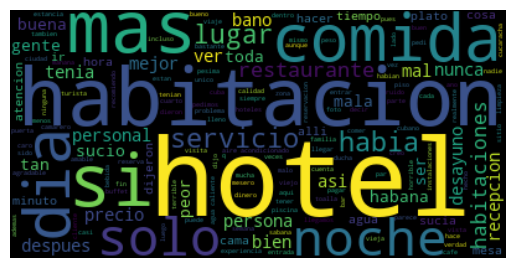

In [22]:
wc = WordCloud().generate("".join(data_class_1["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.2 Clase 2

In [23]:
data_class_2 = reviews_df_final.loc[reviews_df_final['Class']==2]

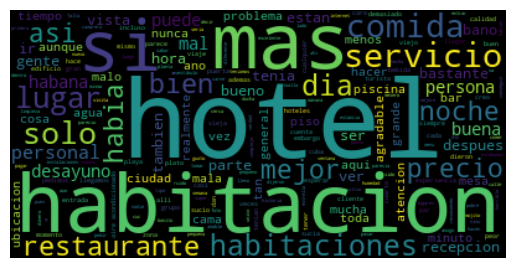

In [24]:
wc = WordCloud().generate("".join(data_class_2["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.3 Clase 3

In [25]:
data_class_3 = reviews_df_final.loc[reviews_df_final['Class']==3]

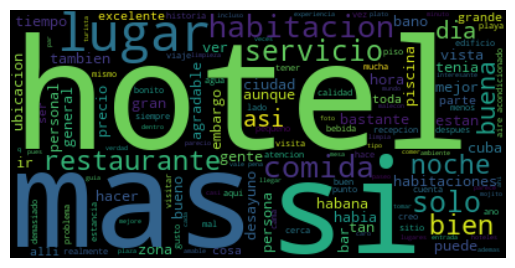

In [26]:
wc = WordCloud().generate("".join(data_class_3["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.4 Clase 4

In [27]:
data_class_4 = reviews_df_final.loc[reviews_df_final['Class']==4]

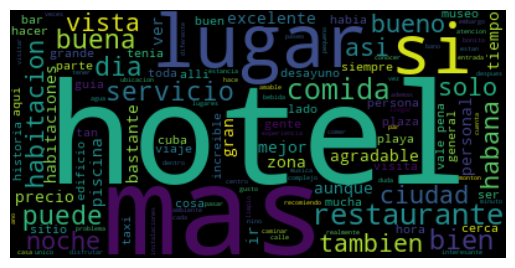

In [28]:
wc = WordCloud().generate("".join(data_class_4["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 2.4.5 Clase 5

In [29]:
data_class_5 = reviews_df_final.loc[reviews_df_final['Class']==5]

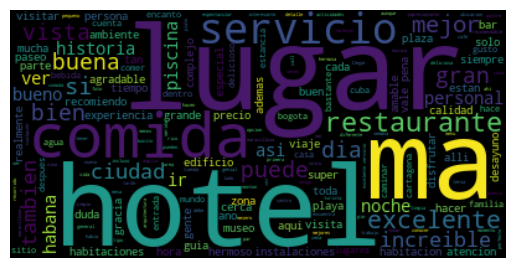

In [30]:
wc = WordCloud().generate("".join(data_class_5["Review"].astype('string')))
# Mostrar la nube de palabras
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2.4.6 Ajustes finales

Se lograron idetificar las siguientes palabras:
- si
- ser
- cada
- hotel
- habit
- mas
- lug

Estas palabras son las que mas frecuencia tenian Y que se compartian entre las clases de reseñas. Muchas de estas palabras pueden ser redudantes en el contexto del problema dado a que son lugares turisticos, ademas de que algunas de ellas pueden tener significado disitinto dependiendo como lo es la palabras `mas`. 

La idea ahora, es eliminar estas palabras del dataframe y dejar los datos listos para los modelos.

In [31]:
stop_words.append("si")
stop_words.append("ser")
stop_words.append("cada")
stop_words.append("hotel")
stop_words.append("habit")
stop_words.append("mas")
stop_words.append("lug")

In [32]:
reviews_df_final["Review"] = reviews_df_final["Review"].apply(word_tokenize).apply(remove_stopwords).apply(" ".join)

In [33]:
reviews_df_final.sample(5)

,Review,Class
6075,gusta popular probar aqui alla aroma casero engentas rapido pues va gustar sazon comida gto malo,3
5529,excelente lugar apreciar naturaleza conocer acerca animales medio crecen asisti tour guiado resolvieron duda tenia centros consumo buenos platillos bebidas basicas,4
7346,atencion mala precios carisimos mesetas creen jefes favor gasten dinero sitio,1
2205,mal limpio servicio suficiente vas quedarte alli semana agradable habitaciones suficientemente equipadas larga estancia negocios bueno do noches suficiente desayuno concurrido personal grosero recomiendo verdad,2
3929,reservamos estancia cuatro dias do habitaciones sucias mal daba asco tumbarte cama almohada apestaba ybtenia monton machasel bano realmente asqueroso habitacion hijas habian goteras ademas mampara ducha dentro banera abria quedo encerrada dentro ducha habitacion manana llovio inundo total levantarnos pedimos cuenta largamos personal inmuto realmente estan acostrubrados quejas quedan igual ademas precio carisimo 365cuc noche habitacion recomiendo regalado volveria alli mundo,1


## 3. Entrenamiento

In [34]:
# The param 'stratify' is useful to guarantee label proportions on train and test sets
X_train, X_test, y_train, y_test = train_test_split(reviews_df_final[["Review"]], reviews_df_final["Class"], test_size=0.3, stratify=reviews_df_final["Class"], random_state=1)

In [35]:
X_train_tokens = [nltk.word_tokenize(text) for text in X_train]
X_test_tokens = [nltk.word_tokenize(text) for text in X_test]

In [36]:
X_train.shape, X_test.shape

((5462, 1), (2342, 1))

In [37]:
pd.Series(y_train).value_counts(normalize=True)

Class
5    0.299707
4    0.251556
3    0.199011
2    0.148663
1    0.101062
Name: proportion, dtype: float64

In [38]:
pd.Series(y_test).value_counts(normalize=True)

Class
5    0.299744
4    0.251494
3    0.198975
2    0.148591
1    0.101196
Name: proportion, dtype: float64

## 4.  Vectorizacion de Texto

In [39]:
bow = CountVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [40]:
X_bow = bow.fit_transform(X_train["Review"])

In [41]:
print("Vocabulary size:", len(bow.vocabulary_))

Vocabulary size: 21327


El modelo TF-IDF (Term Frequency-Inverse Document Frequency) es una técnica utilizada en el procesamiento de lenguaje natural (NLP) para analizar la importancia de una palabra en un documento en relación con una colección de documentos. Es comúnmente utilizado en tareas de minería de texto, recuperación de información y clasificación de texto. En el contexto del negocio, TF-IDF puede ser utilizado para identificar las palabras clave y características más relevantes que contribuyen a la evaluación de un lugar turístico. 

In [42]:
tfidf = TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)

In [43]:
X_tfidf = tfidf.fit_transform(X_train["Review"])

In [44]:
print("Vocabulary size:", len(tfidf.vocabulary_))

Vocabulary size: 21327


## 5. Modelos y Algoritmos

### 5.1. Modelo Random Forest en conjunto con TF-IDF (Nicolas Diaz Montaña)

En este escenario, el algoritmo de Random Forest emerge como una herramienta valiosa para realizar un análisis independiente de los conjuntos de datos de reseñas de sitios turísticos. Principalmente, gracias al manejo robusto que tiene frente al sobreajuste en conjuntos de datos complejos, el Random Forest puede proporcionar información crucial sobre la importancia de diversas características en la calificación de los turistas. Esta interpretación de las características podría ayudar a identificar áreas de mejora en los sitios turísticos y diseñar estrategias efectivas que puede ser de interes para los stakeholders.

In [45]:
tfidf_model = RandomForestClassifier(random_state=3)

In [46]:
tfidf_model.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=3)

<Axes: >

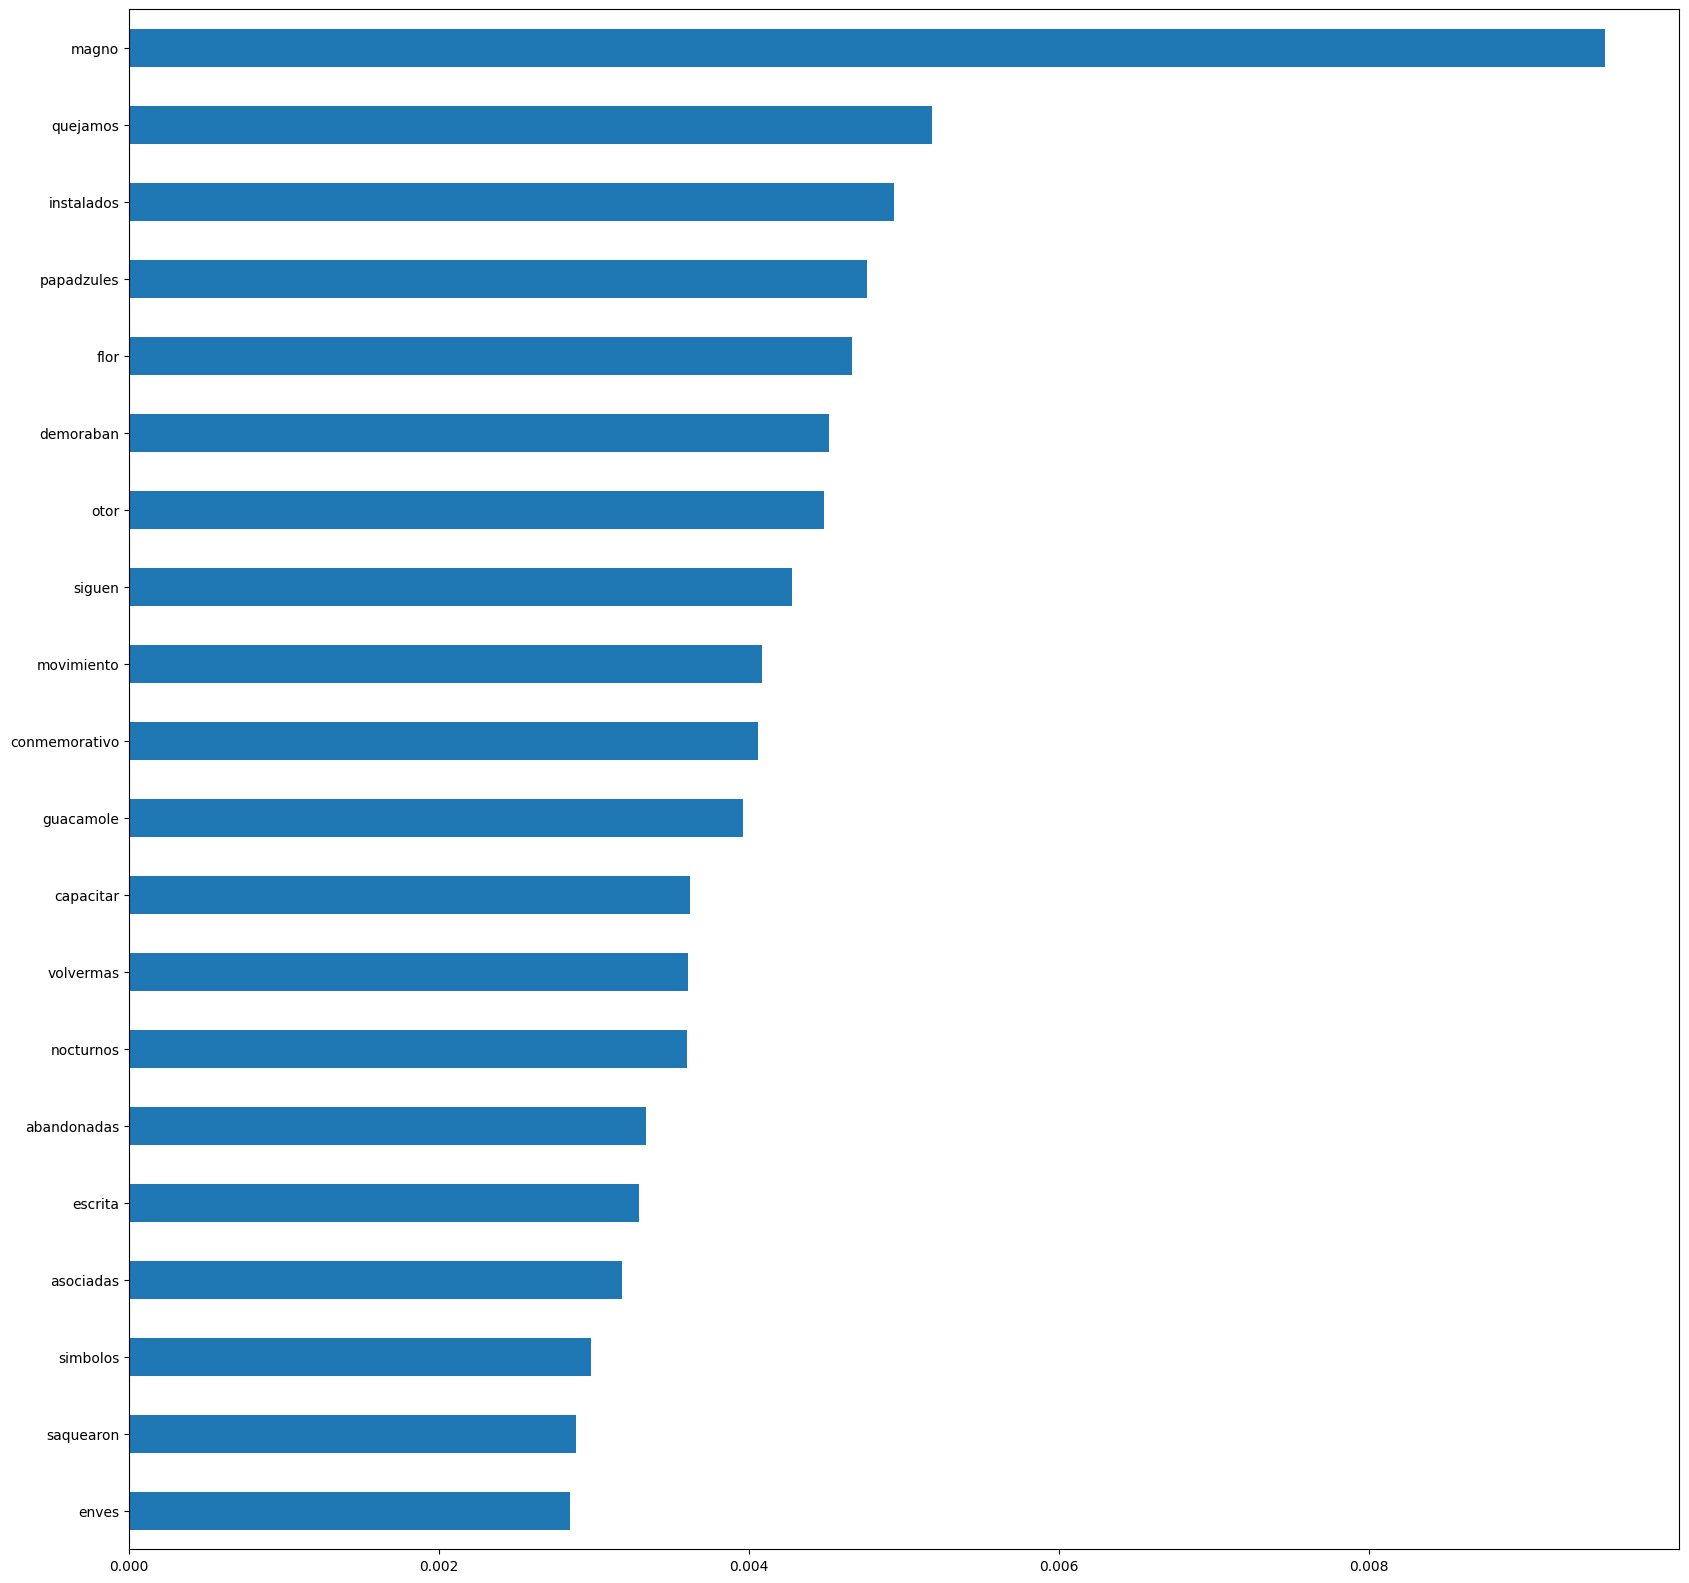

In [47]:
pd.Series(tfidf_model.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(20, 20))

In [48]:
tfidf_estimators = tfidf_model.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 320.45


In [49]:
y_train_tfidf_predict = tfidf_model.predict(X_tfidf)
y_test_tfidf_predict = tfidf_model.predict(tfidf.transform(X_test["Review"]))

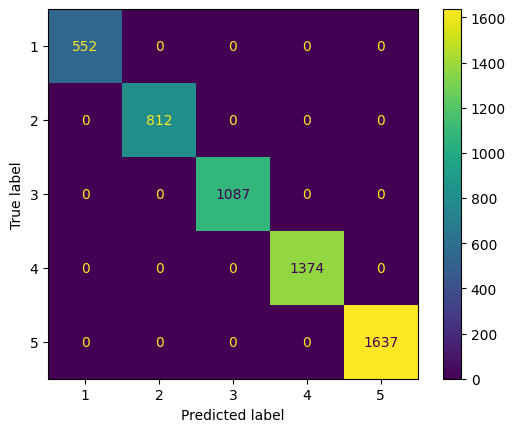

In [50]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

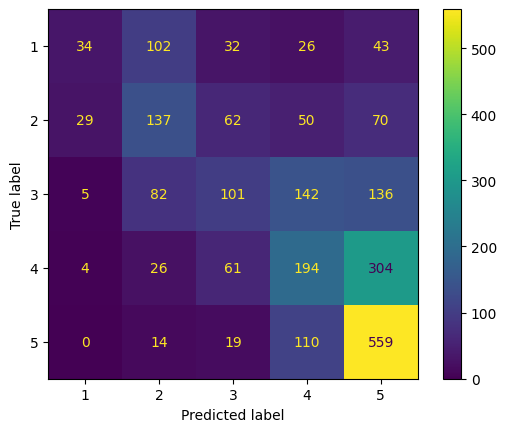

In [51]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [52]:
print(PRINT_PRECISION, precision_score(y_train, y_train_tfidf_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_tfidf_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_tfidf_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [53]:
print(PRINT_PRECISION, precision_score(y_test, y_test_tfidf_predict, average="weighted"))  
print(PRINT_RECALL, recall_score(y_test, y_test_tfidf_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_tfidf_predict, average="weighted"))

Precision: 0.4214032910350411
Recall: 0.4376601195559351
F1: 0.4065035719480803


#### 5.1.1 Segunda iteracion

In [54]:
tfidf_nuevo = RandomForestClassifier(random_state=1)

In [55]:
tfidf_nuevo.fit(X_tfidf, y_train)

RandomForestClassifier(random_state=1)

<Axes: >

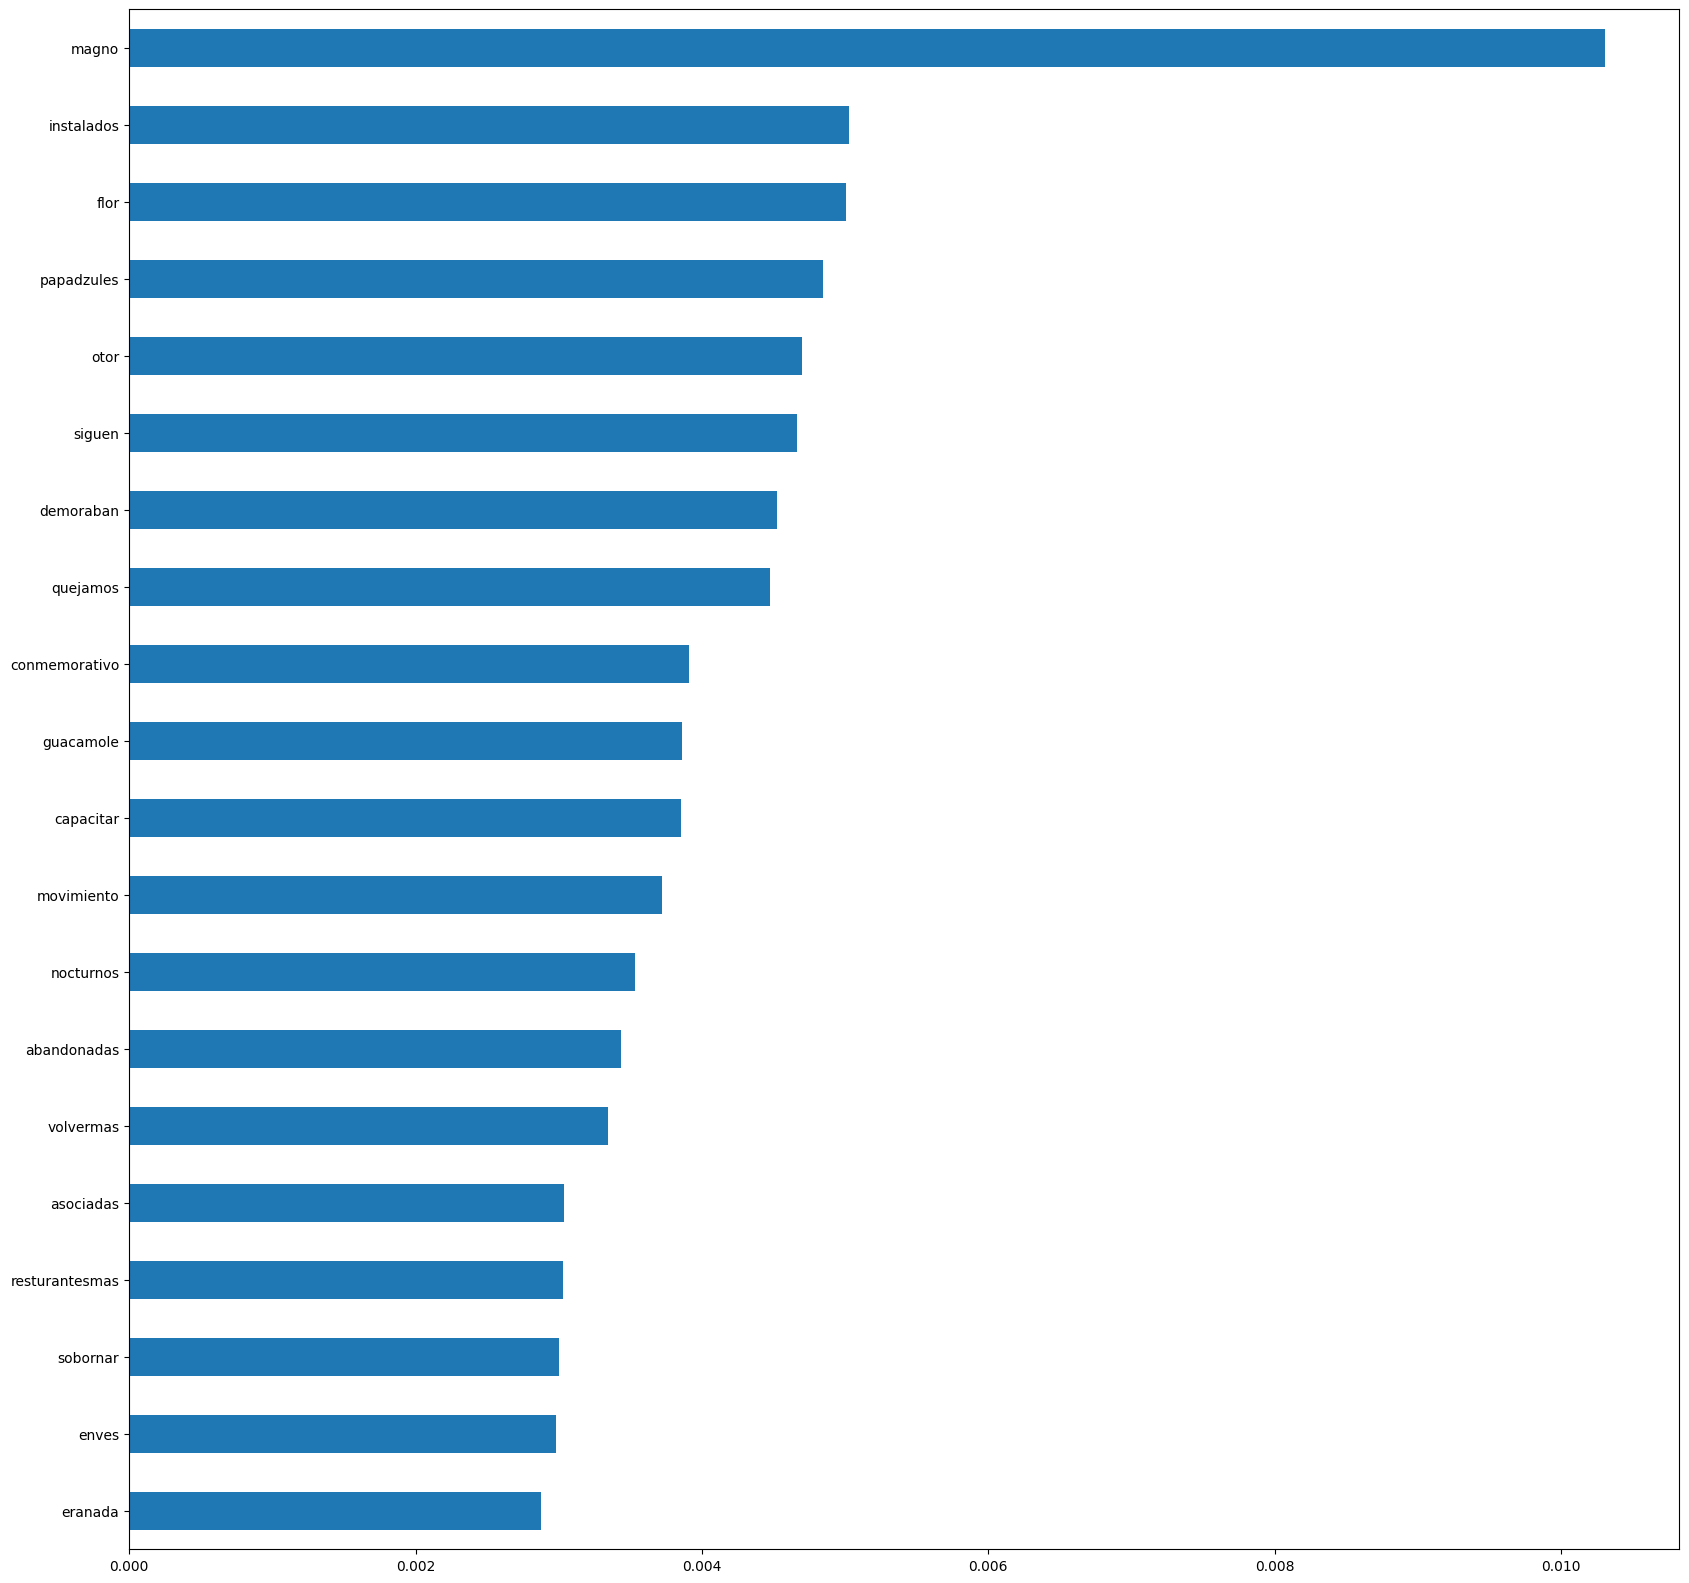

In [56]:
pd.Series(tfidf_nuevo.feature_importances_, index=tfidf.vocabulary_).sort_values().tail(20).plot.barh(figsize=(20, 20))

In [57]:
tfidf_estimators = tfidf_nuevo.estimators_
print("Number of trees:", len(tfidf_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in tfidf_estimators]))
print("min_samples_split (mean):", np.mean([tree.min_samples_split for tree in tfidf_estimators]))
print("min_samples_leaf (mean):", np.mean([tree.min_samples_leaf for tree in tfidf_estimators]))

Number of trees: 100
Trees depth (mean): 327.05
min_samples_split (mean): 2.0
min_samples_leaf (mean): 1.0


In [58]:
y_train_tfidf_predict = tfidf_nuevo.predict(X_tfidf)
y_test_tfidf_predict = tfidf_nuevo.predict(tfidf.transform(X_test["Review"]))

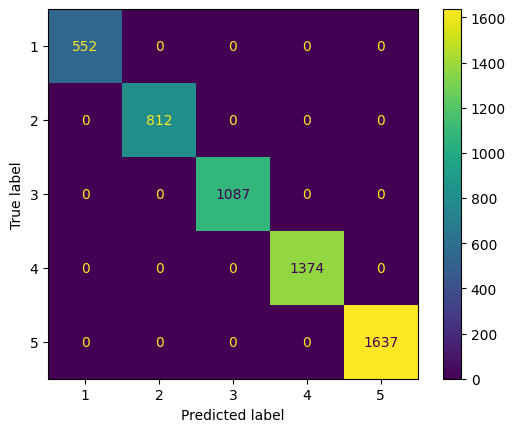

In [59]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_tfidf_predict)

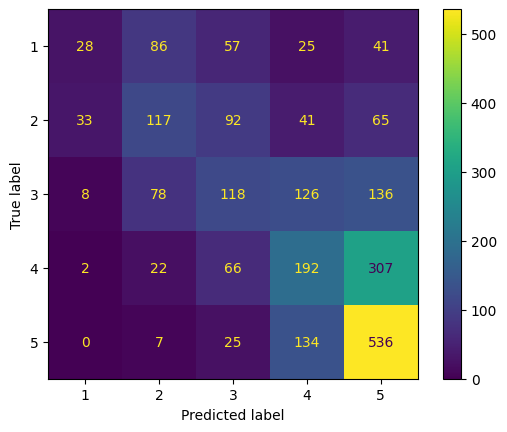

In [60]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_tfidf_predict)

In [61]:
print(PRINT_PRECISION, precision_score(y_train, y_train_tfidf_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_tfidf_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_tfidf_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [62]:
print(PRINT_PRECISION, precision_score(y_test, y_test_tfidf_predict, average="weighted"))  
print(PRINT_RECALL, recall_score(y_test, y_test_tfidf_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_tfidf_predict, average="weighted"))

Precision: 0.4028674474560543
Recall: 0.42314261315115287
F1: 0.3952816238797361


### 5.2 Modelo BoW (Julio Alexander Peña Tovar)

Bag of words (BoW) es una técnica de procesamiento de texto que convierte documentos de texto en vectores numéricos, ignorando el orden de las palabras. Primero, construye un vocabulario a partir de todas las palabras diferentes en nuestro conjunto de datos. Luego, para cada review en nuestra conjunto de datos, cuenta la frecuencia de cada palabra y construye un vector donde cada elemento representa el número de ocurrencias de una palabra específica en la review. Esto resulta en una matriz donde cada fila representa una review y cada columna representa una palabra única del vocabulario.

In [63]:
bow_model = RandomForestClassifier(random_state=2)

In [64]:
bow_model.fit(X_bow, y_train)

RandomForestClassifier(random_state=2)

<Axes: >

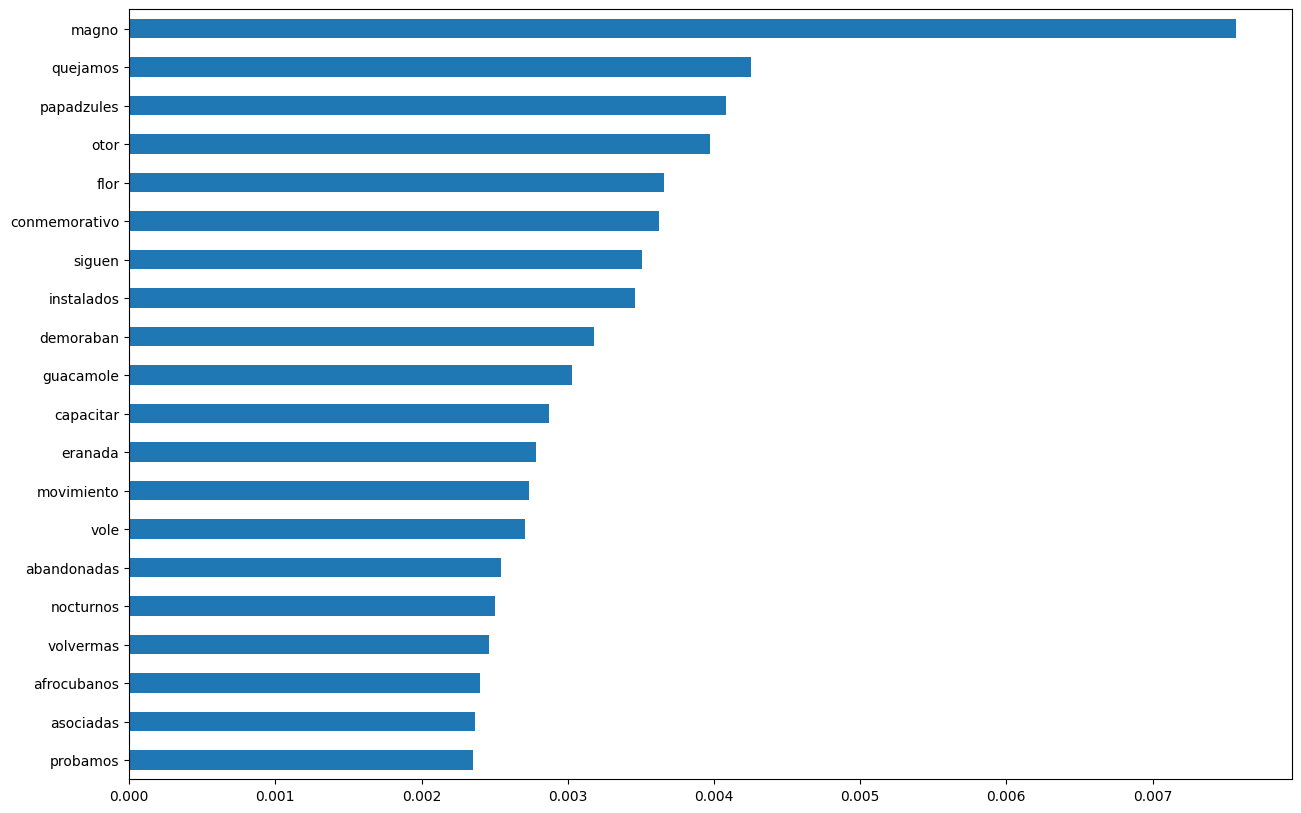

In [65]:
pd.Series(bow_model.feature_importances_, index=bow.vocabulary_).sort_values().tail(20).plot.barh(figsize=(15, 10))

In [66]:
bow_estimators = bow_model.estimators_
print("Number of trees:", len(bow_estimators))
print("Trees depth (mean):", np.mean([tree.get_depth() for tree in bow_estimators]))

Number of trees: 100
Trees depth (mean): 340.94


In [67]:
y_train_bow_predict = bow_model.predict(X_bow)
y_test_bow_predict = bow_model.predict(bow.transform(X_test["Review"]))

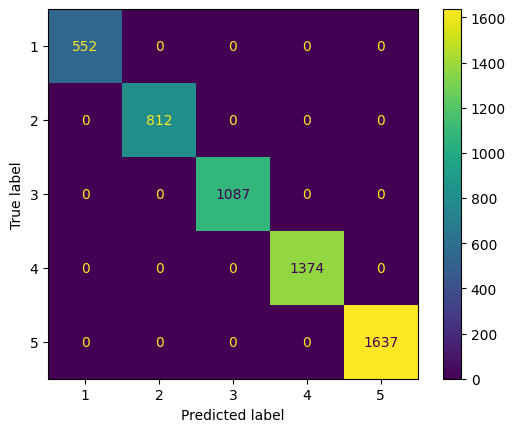

In [68]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_bow_predict)

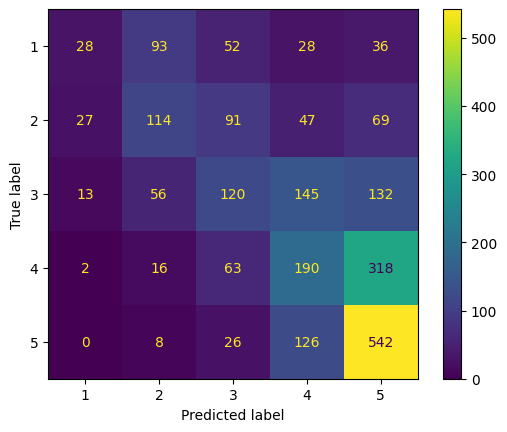

In [69]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_bow_predict)

In [70]:
print(PRINT_PRECISION, precision_score(y_train, y_train_bow_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_bow_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_bow_predict, average="weighted"))

Precision: 1.0
Recall: 1.0
F1: 1.0


In [71]:
print(PRINT_PRECISION, precision_score(y_test, y_test_bow_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_test, y_test_bow_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_bow_predict, average="weighted"))

Precision: 0.4045778774437751
Recall: 0.42442356959863364
F1: 0.3957524663423893


### 5.3 Modelo Naive Bayes en conjunto con TF-IDF (Nicolas Diaz Montaña)

Naive Bayes permite clasificar las reseñas en categorías de sentimiento, mientras que TF-IDF ayuda a identificar las características únicas de cada sitio turístico a partir de las palabras utilizadas en las reseñas. Juntos, estos métodos proporcionan una visión integral de los factores que influyen en la atracción y recomendación de los sitios turísticos.

In [72]:
clf_NB = MultinomialNB()

In [73]:
clf_NB.fit(X_tfidf, y_train)

MultinomialNB()

<Axes: ylabel='Palabra'>

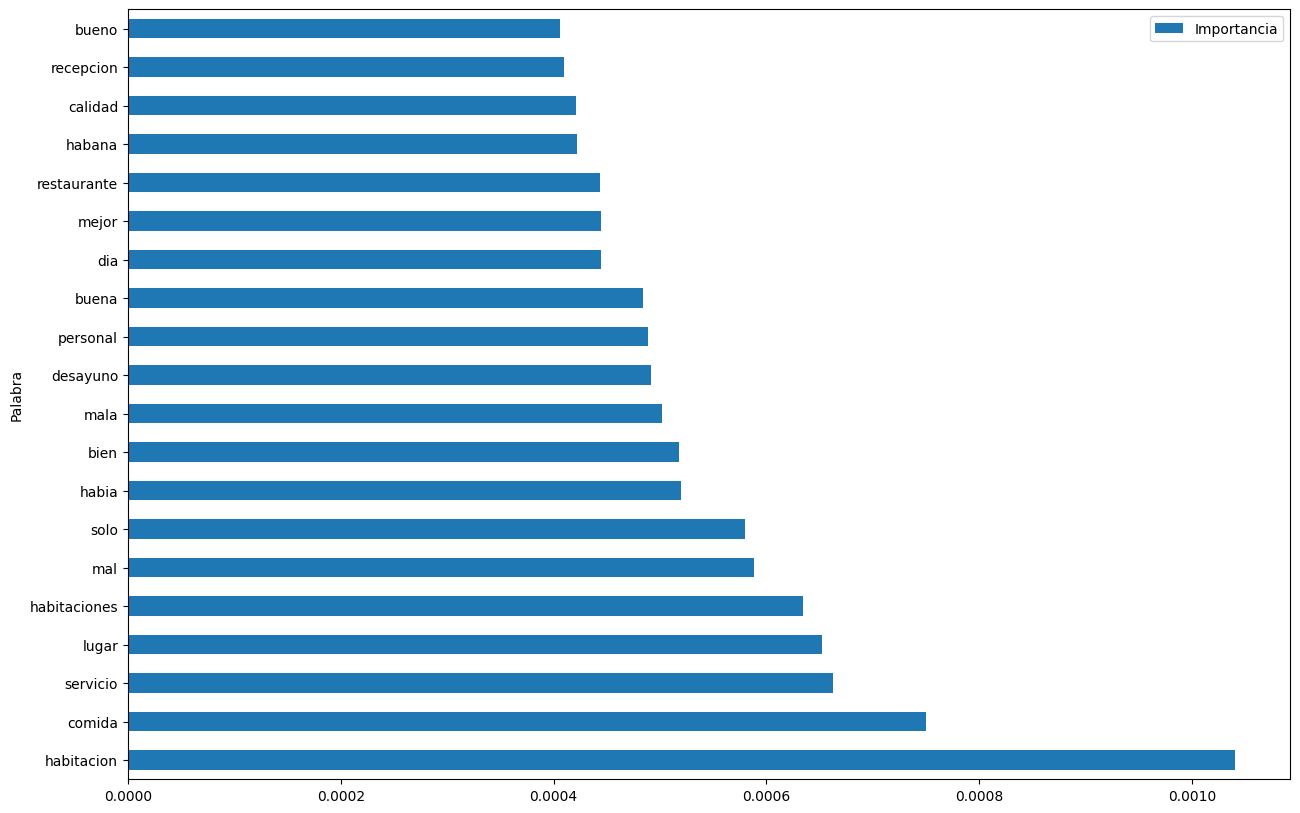

In [74]:
# Obtener las probabilidades logarítmicas de cada clase
log_probs = clf_NB.feature_log_prob_

# Obtener el nombre de las características (palabras)
vocabulario = tfidf.get_feature_names_out()

# Crear un DataFrame para almacenar las palabras y sus importancias
palabras_importantes = pd.DataFrame({"Palabra": vocabulario, "Importancia": np.exp(log_probs[1])})

# Ordenar las palabras por importancia
palabras_importantes = palabras_importantes.sort_values(by="Importancia", ascending=False).reset_index(drop=True)

# Visualizar las palabras más importantes en forma de gráfico de barras
palabras_importantes.head(20).plot.barh(x="Palabra", y="Importancia", figsize=(15, 10))

In [75]:
y_train_NB_predict = clf_NB.predict(X_tfidf)
y_test_NB_predict = clf_NB.predict(tfidf.transform(X_test["Review"]))

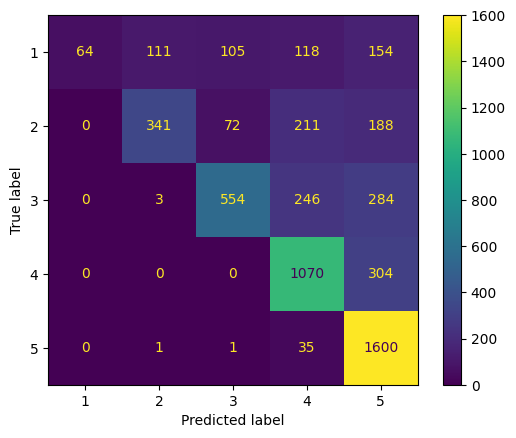

In [76]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_NB_predict)

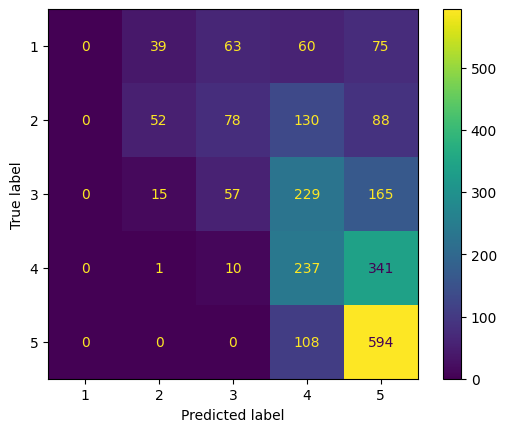

In [77]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_NB_predict)

In [78]:
print(PRINT_PRECISION, precision_score(y_train, y_train_NB_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_NB_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_NB_predict, average="weighted"))

Precision: 0.7126067780092974
Recall: 0.6644086415232515
F1: 0.6286093976149926


In [79]:
print(PRINT_PRECISION, precision_score(y_test, y_test_NB_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_test, y_test_NB_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_NB_predict, average="weighted"))

Precision: 0.34572738633030137
Recall: 0.4013663535439795
F1: 0.3369440706322746


#### 5.3.1 Segunda iteracion

In [80]:
# Definición de la cuadrícula de hiperparámetros
param_grid = {'alpha': [0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1.0, 1.1, 1.2]}

# Inicialización de GridSearchCV
grid_search = GridSearchCV(estimator=MultinomialNB(), param_grid=param_grid, scoring='f1_macro', cv=5)
grid_search.fit(X_tfidf, y_train.values.ravel())

# Obtención de los mejores hiperparámetros
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

Best hyperparameters: {'alpha': 0.8}


In [81]:
nuevo_NB = MultinomialNB(alpha=0.8)

In [82]:
nuevo_NB.fit(X_tfidf, y_train)

MultinomialNB(alpha=0.8)

<Axes: ylabel='Palabra'>

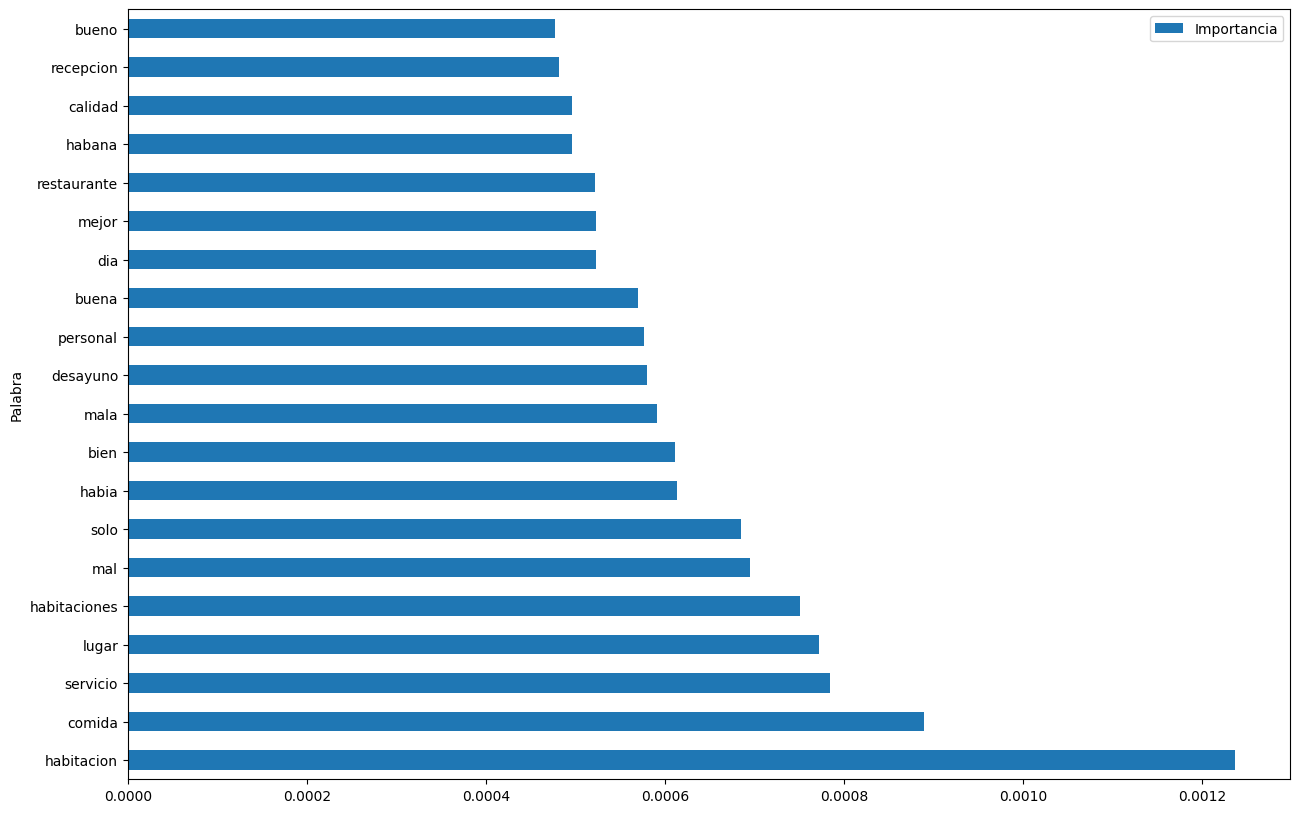

In [83]:
# Obtener las probabilidades logarítmicas de cada clase
log_probs = nuevo_NB.feature_log_prob_

# Obtener el nombre de las características (palabras)
vocabulario = tfidf.get_feature_names_out()

# Crear un DataFrame para almacenar las palabras y sus importancias
palabras_importantes = pd.DataFrame({"Palabra": vocabulario, "Importancia": np.exp(log_probs[1])})

# Ordenar las palabras por importancia
palabras_importantes = palabras_importantes.sort_values(by="Importancia", ascending=False).reset_index(drop=True)

# Visualizar las palabras más importantes en forma de gráfico de barras
palabras_importantes.head(20).plot.barh(x="Palabra", y="Importancia", figsize=(15, 10))

In [84]:
y_train_NB_predict = nuevo_NB.predict(X_tfidf)
y_test_NB_predict = nuevo_NB.predict(tfidf.transform(X_test["Review"]))

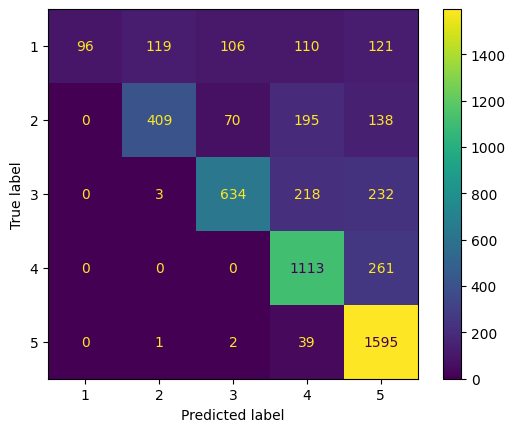

In [85]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_NB_predict)

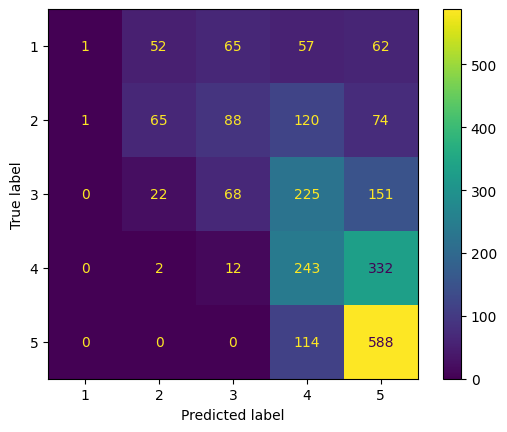

In [86]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_NB_predict)

In [87]:
print(PRINT_PRECISION, precision_score(y_train, y_train_NB_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_NB_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_NB_predict, average="weighted"))

Precision: 0.7415713216336042
Recall: 0.7043207616257781
F1: 0.6769405927719703


In [88]:
print(PRINT_PRECISION, precision_score(y_test, y_test_NB_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_test, y_test_NB_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_NB_predict, average="weighted"))

Precision: 0.4037078315273618
Recall: 0.4120409906063194
F1: 0.35438619132171323


### 5.4 Modelo de Regresión Logistica con TF-IDF (Realizado por Sebastián Casanova Ospina; Revisado por Nicolas Diaz Montaña)

El modelo de regresión logística es un algoritmo de aprendizaje supervisado que se puede utilizar para clasificar y predecir varios resultados (multiclase). En el contexto del negocio, este modelo, en conjunto con el algoritmo TF-IDF, el cual asigna pesos a las palabras más relevantes, proporcionaría las características más relevantes de los lugares turísticos para predecir correctamente las calificaciones de los sitios turísticos.
})

In [89]:
rl_model = LogisticRegression(multi_class='multinomial')
rl_model.fit(X_tfidf, y_train)

LogisticRegression(multi_class='multinomial')

In [90]:
y_train_rl_predict = rl_model.predict(X_tfidf)
y_test_rl_predict = rl_model.predict(bow.transform(X_test["Review"]))

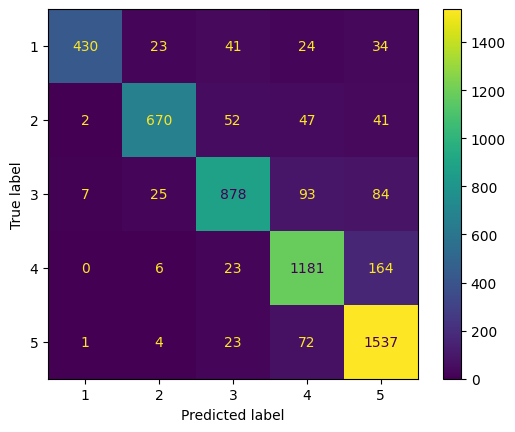

In [91]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_rl_predict)

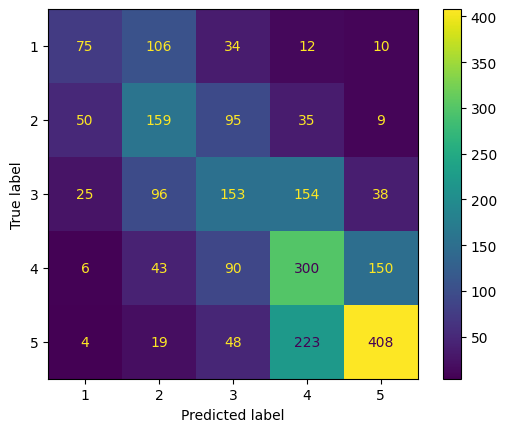

In [92]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_rl_predict)

In [93]:
print(PRINT_PRECISION, precision_score(y_train, y_train_rl_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_rl_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_rl_predict, average="weighted"))

Precision: 0.8647165435091588
Recall: 0.859758330281948
F1: 0.8594098735944925


In [94]:
print(PRINT_PRECISION, precision_score(y_test, y_test_rl_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_test, y_test_rl_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_rl_predict, average="weighted"))

Precision: 0.47883742534023715
Recall: 0.46754910333048677
F1: 0.4688855729270647


## 6. Prueba del modelo

Teniendo en cuenta las indicaciones que se nos dieron, pasaremos a asignar calificaciones a un documento con solo reseñas, para evaluar su calidad.

In [95]:
# Cargar el nuevo conjunto de datos con solo reseñas
nuevas_reseñas_df = pd.read_csv("../data/particion_prueba_estudiantes.csv")

Haremos un pequeño arreglo a alos datos y los prepararemos para posteriormente evaluarlos.

In [96]:
# Preprocesamiento de las nuevas reseñas
nuevas_reseñas_df["Review"] = nuevas_reseñas_df["Review"].apply(word_tokenize).apply(preprocessing).apply(normalize).apply(" ".join)

# Vectorización de las nuevas reseñas
X_nuevas_reseñas_tfidf = tfidf.transform(nuevas_reseñas_df["Review"])

Posteriormente haremos la prediccion de las calificaciones.

In [97]:
# Predicción de las calificaciones
calificaciones_predichas = rl_model.predict(X_nuevas_reseñas_tfidf)

# Truncar las calificaciones predichas para que estén dentro del rango de 0 a 5
calificaciones_predichas_truncadas = np.clip(calificaciones_predichas, 0, 5)

Debemos guardar las calificaciones y exportarlo a un documento.

In [98]:
# Asignación de las calificaciones predichas al nuevo conjunto de datos
nuevas_reseñas_df["Class"] = calificaciones_predichas_truncadas

# Guardar el nuevo conjunto de datos con las calificaciones asignadas
nuevas_reseñas_df.to_csv("../data/nuevas_reseñas_con_calificaciones.csv", index=False)

## 7. Pipeline

In [99]:
pipeline = Pipeline(steps = [
    ("vectorizer", TfidfVectorizer(tokenizer=word_tokenize, stop_words=stop_words, lowercase=True)),
    ("classifier", LogisticRegression(multi_class='multinomial')),
])

In [100]:
param_grid = {
    'vectorizer__max_features': [None, 1000, 2000],  # Vary the maximum number of features
    'vectorizer__ngram_range': [(1, 1), (1, 2)],  # Vary the ngram range
    'classifier__C': [0.1, 1.0, 10.0],  # Vary the regularization parameter
    'classifier__solver': ['newton-cg', 'sag', 'saga']  # Solvers compatible with multinomial logistic regression
}


In [101]:
search = RandomizedSearchCV(pipeline, param_grid, n_iter=10, scoring=["precision", "recall", "f1"], refit="f1", cv=5, return_train_score=True, verbose=1, random_state=1)

In [102]:
search.fit(X_train["Review"], y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vectorizer',
                                              TfidfVectorizer(stop_words=['de',
                                                                          'la',
                                                                          'que',
                                                                          'el',
                                                                          'en',
                                                                          'y',
                                                                          'a',
                                                                          'los',
                                                                          'del',
                                                                          'se',
                                                                          'las',
                                                                          'por',
                                                                          'un',
                                                                          'para',
                                                                          'con',
                                                                          'no',
                                                                          'una',
                                                                          'su',
                                                                          'al',
                                                                          'lo',
                                                                          'como',
                                                                          'más',
                                                                          'pero',
                                                                          'sus',
                                                                          'le',
                                                                          'ya',
                                                                          'o',
                                                                          'este',
                                                                          'sí',
                                                                          'porque', ...],
                                                              tokenizer=<function word_tokenize at 0x0000023692F39E10>)),
                                             ('classifier',
                                              LogisticRegression(multi_class='multinomial'))]),
                   param_distributions={'classifier__C': [0.1, 1.0, 10.0],
                                        'classifier__solver': ['newton-cg',
                                                               'sag', 'saga'],
                                        'vectorizer__max_features': [None, 1000,
                                                                     2000],
                                        'vectorizer__ngram_range': [(1, 1),
                                                                    (1, 2)]},
                   random_state=1, refit='f1', return_train_score=True,
                   scoring=['precision', 'recall', 'f1'], verbose=1)

In [103]:
search.best_params_

{'vectorizer__ngram_range': (1, 1),
 'vectorizer__max_features': None,
 'classifier__solver': 'saga',
 'classifier__C': 1.0}

In [104]:
search.best_score_

nan

In [105]:
y_train_search_predict = search.best_estimator_.predict(X_train["Review"])
y_test_search_predict = search.best_estimator_.predict(X_test["Review"])

In [106]:
print(PRINT_PRECISION, precision_score(y_train, y_train_search_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_train, y_train_search_predict, average="weighted"))
print(PRINT_F1, f1_score(y_train, y_train_search_predict, average="weighted"))

Precision: 0.8643148662072675
Recall: 0.8593921640424753
F1: 0.8590478489393191


In [107]:
print(PRINT_PRECISION, precision_score(y_test, y_test_search_predict, average="weighted"))
print(PRINT_RECALL, recall_score(y_test, y_test_search_predict, average="weighted"))
print(PRINT_F1, f1_score(y_test, y_test_search_predict, average="weighted"))

Precision: 0.4644111500170227
Recall: 0.4730999146029035
F1: 0.46001842090565853


In [114]:
filename = '../API/assets/model.joblib'

In [115]:
dump(search, filename)

['../API/assets/model.joblib']